## Torus visualisation
The goal here is to visualize the unbiased kernel estimation of a spectral density.

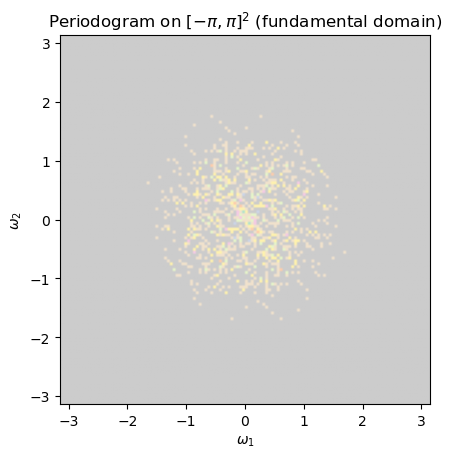

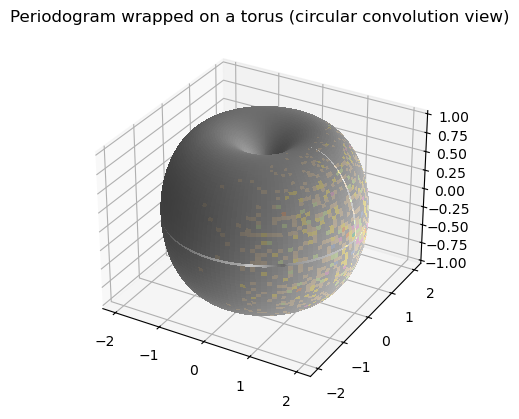

In [29]:
# Load user's helpers
import numpy as np, matplotlib.pyplot as plt
import source as user_src

import torch

# --- 1) Generate a lattice field and its periodogram using user's helpers ---
torch.manual_seed(0)

# Simple MA kernel for a quick stationary sample
K = torch.full((3, 3), 0.3, dtype=torch.float32)
K[1, 1] = 1.0

sampler = user_src.gridMA(K)
N = M = 128
x = sampler(N, M, T=1)[0, 0]

# Periodogram on the torus (already fftshifted in user_src.I)
I_flat = user_src.I(x)

# Normalize to [0,1] for coloring
I_norm = (I_flat - I_flat.min()) / (I_flat.max() - I_flat.min() + 1e-12)
I_np = I_norm.numpy()
colors = plt.cm.Pastel2_r(I_np)

# --- 2) Standard (flat) periodogram plot (its natural fundamental domain) ---
fig1 = plt.figure()
plt.imshow(colors, origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], aspect="equal")
plt.title("Periodogram on $[-\\pi,\\pi]^2$ (fundamental domain)")
plt.xlabel("$\\omega_1$")
plt.ylabel("$\\omega_2$")


# --- 3) Periodogram mapped onto a torus via periodic wrapping ---
# Parametrize torus
R, r = 1, 1
u = np.linspace(0, 2*np.pi, N, endpoint=False)  # corresponds to omega_1
v = np.linspace(0, 2*np.pi, M, endpoint=False)  # corresponds to omega_2
U, V = np.meshgrid(u, v, indexing="ij")

X = (R + r*np.cos(V)) * np.cos(U)
Y = (R + r*np.cos(V)) * np.sin(U)
Z = r * np.sin(V)

# Map periodogram onto torus surface as colors (wrap via modulo indices)
# I_np is already N x M, aligned to frequencies; shift from [-pi,pi] to [0,2pi) by roll
I_wrapped = np.roll(np.roll(I_np, N//2, axis=0), M//2, axis=1)

# Create RGBA colors using default colormap without specifying a style
colors = plt.cm.Pastel2_r(I_wrapped)  # using default colormap for clarity

fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colors, linewidth=0, antialiased=False)
ax.set_title("Periodogram wrapped on a torus (circular convolution view)")
plt.show()


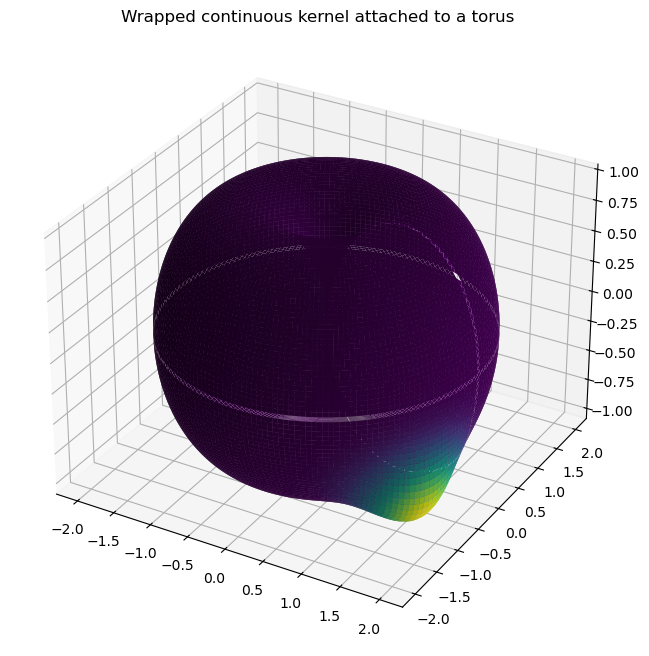

In [30]:
# Retry without using mathtext requiring \mathbb in title
import numpy as np
import matplotlib.pyplot as plt

R, r = 1, 1.0
N_u, N_v = 200, 160
u = np.linspace(0, 2*np.pi, N_u, endpoint=False)
v = np.linspace(0, 2*np.pi, N_v, endpoint=False)
U, V = np.meshgrid(u, v, indexing="ij")

u0, v0 = 1.85*np.pi, 1.75*np.pi

def wrap_diff(a, a0):
    return (a - a0 + np.pi) % (2*np.pi) - np.pi

h = 0.25
Udiff = wrap_diff(U, u0)
Vdiff = wrap_diff(V, v0)
K = np.exp(-0.5*((Udiff/h)**2 + (Vdiff/h)**2))

amplitude = 0.35
r_mod = r + amplitude*K

X = (R + r_mod*np.cos(V)) * np.cos(U)
Y = (R + r_mod*np.cos(V)) * np.sin(U)
Z = r_mod * np.sin(V)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.viridis(K), linewidth=0, antialiased=True)
ax.set_title("Wrapped continuous kernel attached to a torus")
plt.show()


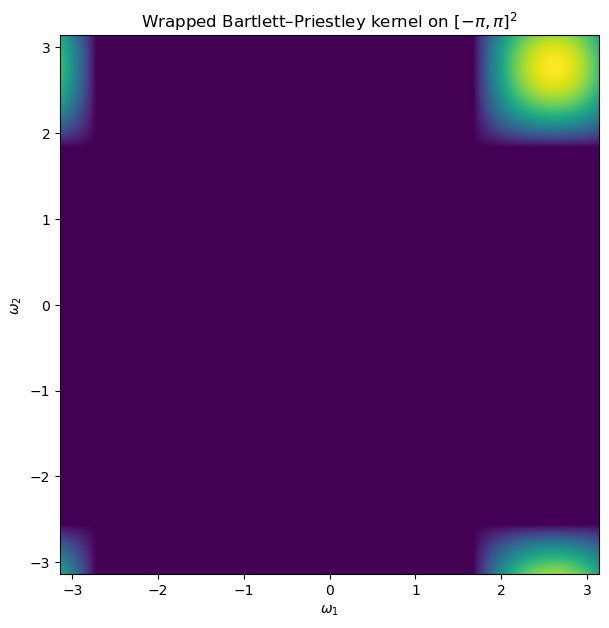

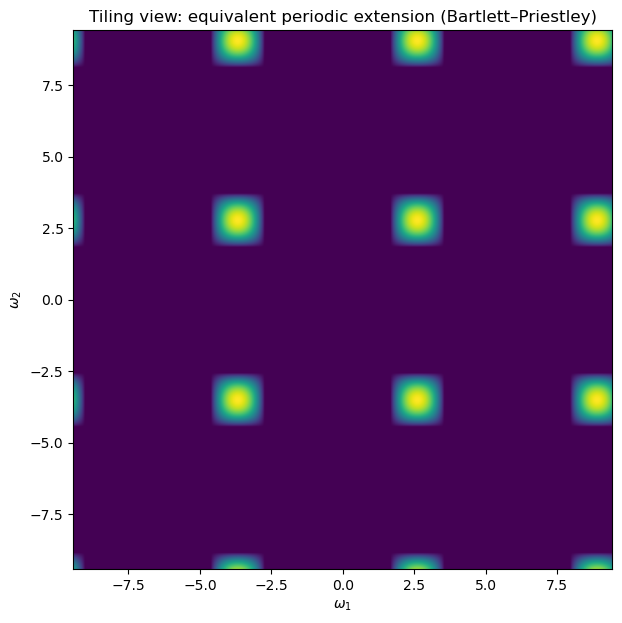

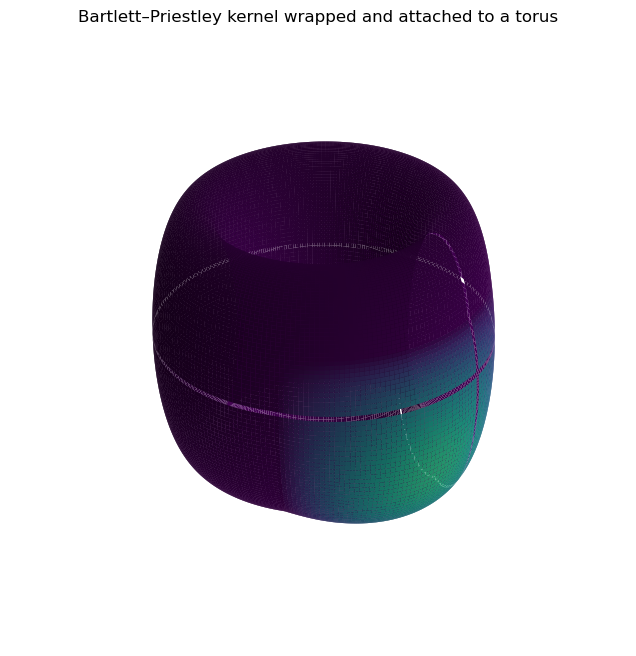

In [4]:
# Re-run after a kernel reset: Bartlett–Priestley kernel on the torus
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def wrap_diff(angle, center):
    return (angle - center + np.pi) % (2*np.pi) - np.pi

def bp_kernel_1d(delta, h):
    u = delta / h
    out = np.zeros_like(u, dtype=float)
    mask = np.abs(u) <= np.pi
    out[mask] = (1.0/h) * (3.0/(4.0*np.pi)) * (1.0 - (u[mask]/np.pi)**2)
    return out

def bp_kernel_2d_wrapped(W1, W2, center, h):
    d1 = wrap_diff(W1, center[0])
    d2 = wrap_diff(W2, center[1])
    return bp_kernel_1d(d1, h) * bp_kernel_1d(d2, h)

# Fundamental domain grid
N = M = 256
w1 = np.linspace(-np.pi, np.pi, N, endpoint=False)
w2 = np.linspace(-np.pi, np.pi, M, endpoint=False)
W1, W2 = np.meshgrid(w1, w2, indexing="ij")

omega0 = (0.88*np.pi, 0.83*np.pi)
h = 0.30

K_wrap = bp_kernel_2d_wrapped(W1, W2, omega0, h)

plt.figure(figsize=(7,7))
plt.imshow(K_wrap, origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], aspect="equal")
plt.title("Wrapped Bartlett–Priestley kernel on $[-\\pi,\\pi]^2$")
plt.xlabel("$\\omega_1$"); plt.ylabel("$\\omega_2$")
plt.show()

tile = np.block([[K_wrap, K_wrap, K_wrap],
                 [K_wrap, K_wrap, K_wrap],
                 [K_wrap, K_wrap, K_wrap]])

L = 3*np.pi
plt.figure(figsize=(9,7))
plt.imshow(tile, origin="lower", extent=[-L, L, -L, L], aspect="equal")
plt.title("Tiling view: equivalent periodic extension (Bartlett–Priestley)")
plt.xlabel("$\\omega_1$"); plt.ylabel("$\\omega_2$")
plt.show()

# Torus render with wrapped BP kernel as a bump
R, r = 3.0, 1.0
Nu, Nv = 220, 180
u = np.linspace(0, 2*np.pi, Nu, endpoint=False)
v = np.linspace(0, 2*np.pi, Nv, endpoint=False)
U, V = np.meshgrid(u, v, indexing="ij")

K_torus = bp_kernel_2d_wrapped(U - np.pi, V - np.pi, (omega0[0], omega0[1]), h)

amp = 0.45
r_mod = r + amp*K_torus

X = (R + r_mod*np.cos(V)) * np.cos(U)
Y = (R + r_mod*np.cos(V)) * np.sin(U)
Z = r_mod * np.sin(V)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.viridis(K_torus), linewidth=0, antialiased=True)
ax.set_axis_off()
ax.set_title("Bartlett–Priestley kernel wrapped and attached to a torus")
plt.show()


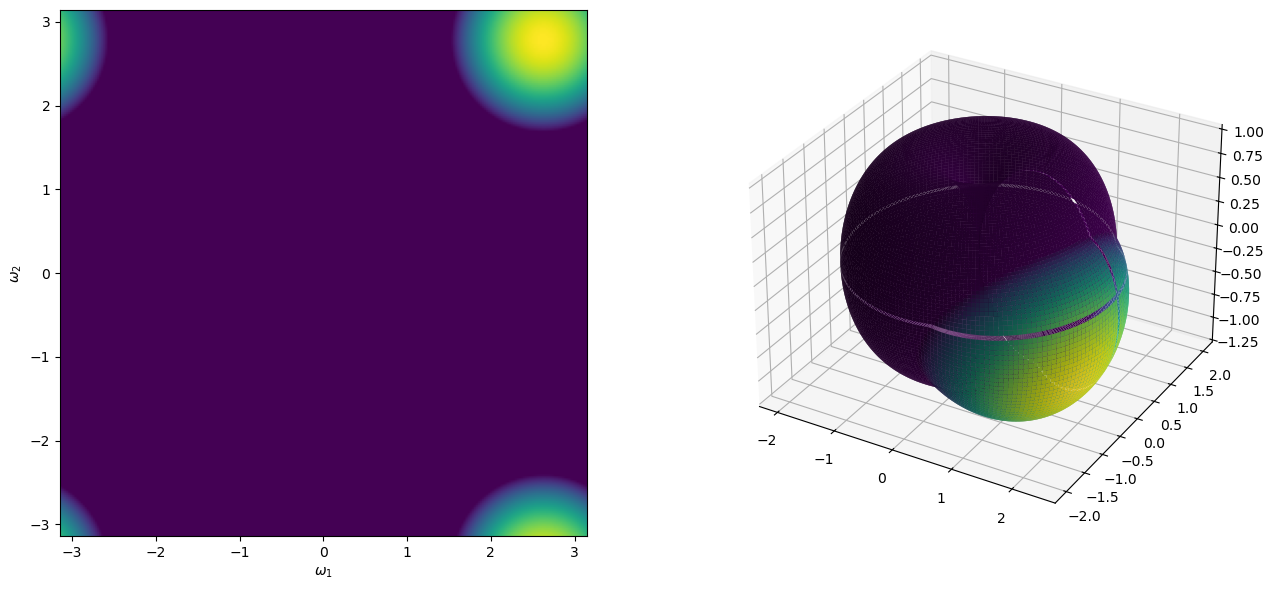

In [7]:
# Side-by-side: wrapped Euclidean Bartlett–Priestley kernel (heatmap) and the same kernel attached to a torus
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- helpers ---
def wrap_diff(angle, center):
    """Wrapped difference on (-pi, pi]."""
    return (angle - center + np.pi) % (2*np.pi) - np.pi

def bp_euclid_wrapped(W1, W2, center, h):
    """
    Euclidean (radial) Bartlett–Priestley kernel on the torus.
    Profile: K(u) ∝ (1 - (u/π)^2)_+, with u = sqrt((Δω1/h)^2 + (Δω2/h)^2).
    We use a constant so the peak is 1; visualization focuses on shape, not normalization.
    """
    d1 = wrap_diff(W1, center[0]) / h
    d2 = wrap_diff(W2, center[1]) / h
    u = np.sqrt(d1**2 + d2**2)
    K = np.maximum(0.0, 1.0 - (u/np.pi)**2)
    return K

# --- grid on fundamental domain ---
N = M = 256
w1 = np.linspace(-np.pi, np.pi, N, endpoint=False)
w2 = np.linspace(-np.pi, np.pi, M, endpoint=False)
W1, W2 = np.meshgrid(w1, w2, indexing="ij")

# Center and bandwidth
omega0 = (0.88*np.pi, 0.83*np.pi)
h = 0.35  # radians

K_wrap = bp_euclid_wrapped(W1, W2, omega0, h)

# --- torus geometry ---
R, r = 1, 1.0
Nu, Nv = 220, 180
u = np.linspace(0, 2*np.pi, Nu, endpoint=False)
v = np.linspace(0, 2*np.pi, Nv, endpoint=False)
U, V = np.meshgrid(u, v, indexing="ij")

# Evaluate the same wrapped kernel in (U,V) coordinates (shift by pi to map [0,2pi) -> [-pi,pi))
K_torus = bp_euclid_wrapped(U - np.pi, V - np.pi, omega0, h)

# Attach as bump
amp = 0.5
r_mod = r + amp*K_torus
X = (R + r_mod*np.cos(V)) * np.cos(U)
Y = (R + r_mod*np.cos(V)) * np.sin(U)
Z = r_mod * np.sin(V)

# --- Plot: side-by-side ---
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
im = ax1.imshow(K_wrap, origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi], aspect="equal")
# ax1.set_title("Wrapped Euclidean BP kernel on $[-\\pi,\\pi]^2$")
ax1.set_xlabel("$\\omega_1$"); ax1.set_ylabel("$\\omega_2$")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.viridis(K_torus), linewidth=0, antialiased=True)
# ax2.set_title("Same kernel attached to a torus")

plt.tight_layout()
plt.show()
